In [1]:
# Importing Libraries.
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.mllib import numpy as np

spark = SparkSession.builder.appName("Hotels_Information").getOrCreate() # Creating a spark session.

In [2]:
# File paths - used for dynamic changes of the files' path.
hotelsDataCSV = 'hotels_data.csv' # original data file
folderPath = 'C:/Users/Meitar/ProjectDataScience/' # The base folder path.
outputFolder = 'output/' # General output folder.

# Opening the data file.
hotel_data = spark.read.csv(folderPath+hotelsDataCSV, header=True, inferSchema=True) 

# First, we will find the first Top 150 Hotels with the greatest number of records.

In [3]:
# Grouping the hotels by the 'Hotel Name', then creating a sub-dataSet that contains the 
# amount of records by 'Hotel Name', then we sort by Decending order.
# after we only take the first 150 records, we join the information from the original data set to chose only the relevant hotels.
Top150Hotels = hotel_data.groupBy('Hotel Name').count().sort('count', ascending = False).limit(150).join(hotel_data, 'Hotel Name').drop('count')

#saving the information to a file
Top150Hotels.toPandas().to_csv(folderPath+outputFolder+'Top150Hotels.csv')

# Now, from the Top150Hotels table, we will take the top 40 Checkin Dates by the number of records.

In [4]:
# By the same process, we chose top 40 records of 'Checkin Date'. 
Top40Checkin = Top150Hotels.groupBy('Checkin Date').count().sort('count', ascending = False).limit(40).join(Top150Hotels, 'Checkin Date').drop('count')

In [5]:
#saving the information to a file
Top40Checkin.toPandas().to_csv(folderPath+outputFolder+'Top40CheckinDatesFromTop150Hotels.csv') 

# Now, from the Top40Checkin Dates, we will take the 4 prices for each of 4 Discount Code ('Coupon')

# The Discount Codes are: 1,2,3 and 4.


## We need to complete the missing information with the value of -1.

In [6]:
# Using the Pandas' read_csv for converting the irrelevant data.
Top40Checkin = pd.read_csv(folderPath+outputFolder+'Top40CheckinDatesFromTop150Hotels.csv',encoding='ISO-8859-1', index_col=0)

# Converting the columns as strings so the future algorithms won't count them as vector information.
Top40Checkin['Discount Price'] = Top40Checkin['Discount Price'].astype(float)
Top40Checkin['Discount Code'] = Top40Checkin['Discount Code'].astype(str)

# Converting the codes to an index of: Discount Code #1 -> index '0', Discount Code #2 -> index '1'...
Top40Checkin['Discount Code'] = Top40Checkin['Discount Code'].replace(1,0)
Top40Checkin['Discount Code'] = Top40Checkin['Discount Code'].replace(2,1)
Top40Checkin['Discount Code'] = Top40Checkin['Discount Code'].replace(3,2)
Top40Checkin['Discount Code'] = Top40Checkin['Discount Code'].replace(4,3)
                                  
Top40Checkin['Checkin Date'] = Top40Checkin['Checkin Date'].astype(str)

# Using the pivot_table method to cross-check what information is missing (some hotels don't have codes for all the dates) 
MissingInformation = Top40Checkin.pivot_table(values=['Discount Price'], index=['Hotel Name'], columns=['Checkin Date','Discount Code'], aggfunc={'Discount Price': np.min})
MissingInformation.columns = MissingInformation.columns.droplevel(0)

# Adding the lable of [Date]_Price# (# = 1, 2, 3 and 4 for the coupon numbers) for a single cell representing a parallel Hotel. 
MissingInformation.columns = ['_Price'.join(col).strip() for col in MissingInformation.columns.values]

# Replacing the missing information with -1.
MissingInformation = MissingInformation.fillna(-1.0) 

# Saving to a file.
MissingInformation.to_csv(folderPath+outputFolder+'MissingInformation.csv') 

# Normalizing Data

In [7]:
# Finding the maximum and minimum Discount Price
MissingInformation = pd.read_csv(folderPath+outputFolder+'MissingInformation.csv',encoding='ISO-8859-1',index_col=0) #opening the file

# Now, we Normalizing the values between 0 to 100.

In [8]:
# Going over the table to find the minimum and maximum values of prices.

#Min and Max Discount Prices to arrage between 0 and 100.
maxDiscountPrice = 0.0
minDiscountPrice = 999999.9

# Indexes
j=0 #rows
i=0 #columns

#going over each cell in the Table, if it's a cell that contains information about the relevant Discount Prices.
for index, row in MissingInformation.iterrows():
    if index != 'Checkin Date' and index != 'Discount Code' and index != 'Hotel Name' and index != '':
        i=0
        for cell in row:
            if float(cell) >= float(maxDiscountPrice):
                maxDiscountPrice = cell
            if float(cell) <= float(minDiscountPrice) and cell != -1.0:
                minDiscountPrice = cell
            i = i + 1
    j = j + 1

## Now that we have the minimum and maximum range of the prices, we adjust them accordingly.

In [9]:
MissingInformation = pd.read_csv(folderPath+outputFolder+'MissingInformation.csv',encoding='ISO-8859-1',index_col=0)

j=0 #rows
i=0 #columns

for index, row in MissingInformation.iterrows():
    if index != 'Checkin Date' and index != 'Discount Code' and index != 'Hotel Name' and index != '':
        i=0
        for cell in row:
            if cell != -1.0:
                value = (float(cell) - float(minDiscountPrice)) / (float(maxDiscountPrice) - float(minDiscountPrice))
                MissingInformation.iat[j,i] = float(round(value * 100))
            else:
                MissingInformation.iat[j,i] = float('-1.0')
            i = i + 1
    j = j + 1
    
# Saving the normalization data to a new file.
MissingInformation.to_csv(folderPath+outputFolder+'NormalizedPrices.csv',encoding='ISO-8859-1',index=True) 

#  Hierarchical Clustering

In [10]:
# Importing statistical visualization library.
import scipy.cluster.hierarchy as hac
from matplotlib import pyplot as plt

In [11]:
# Reading the file.
NormalizedPrices = pd.read_csv(folderPath + outputFolder + 'NormalizedPrices.csv', encoding='ISO-8859-1', index_col=[0])

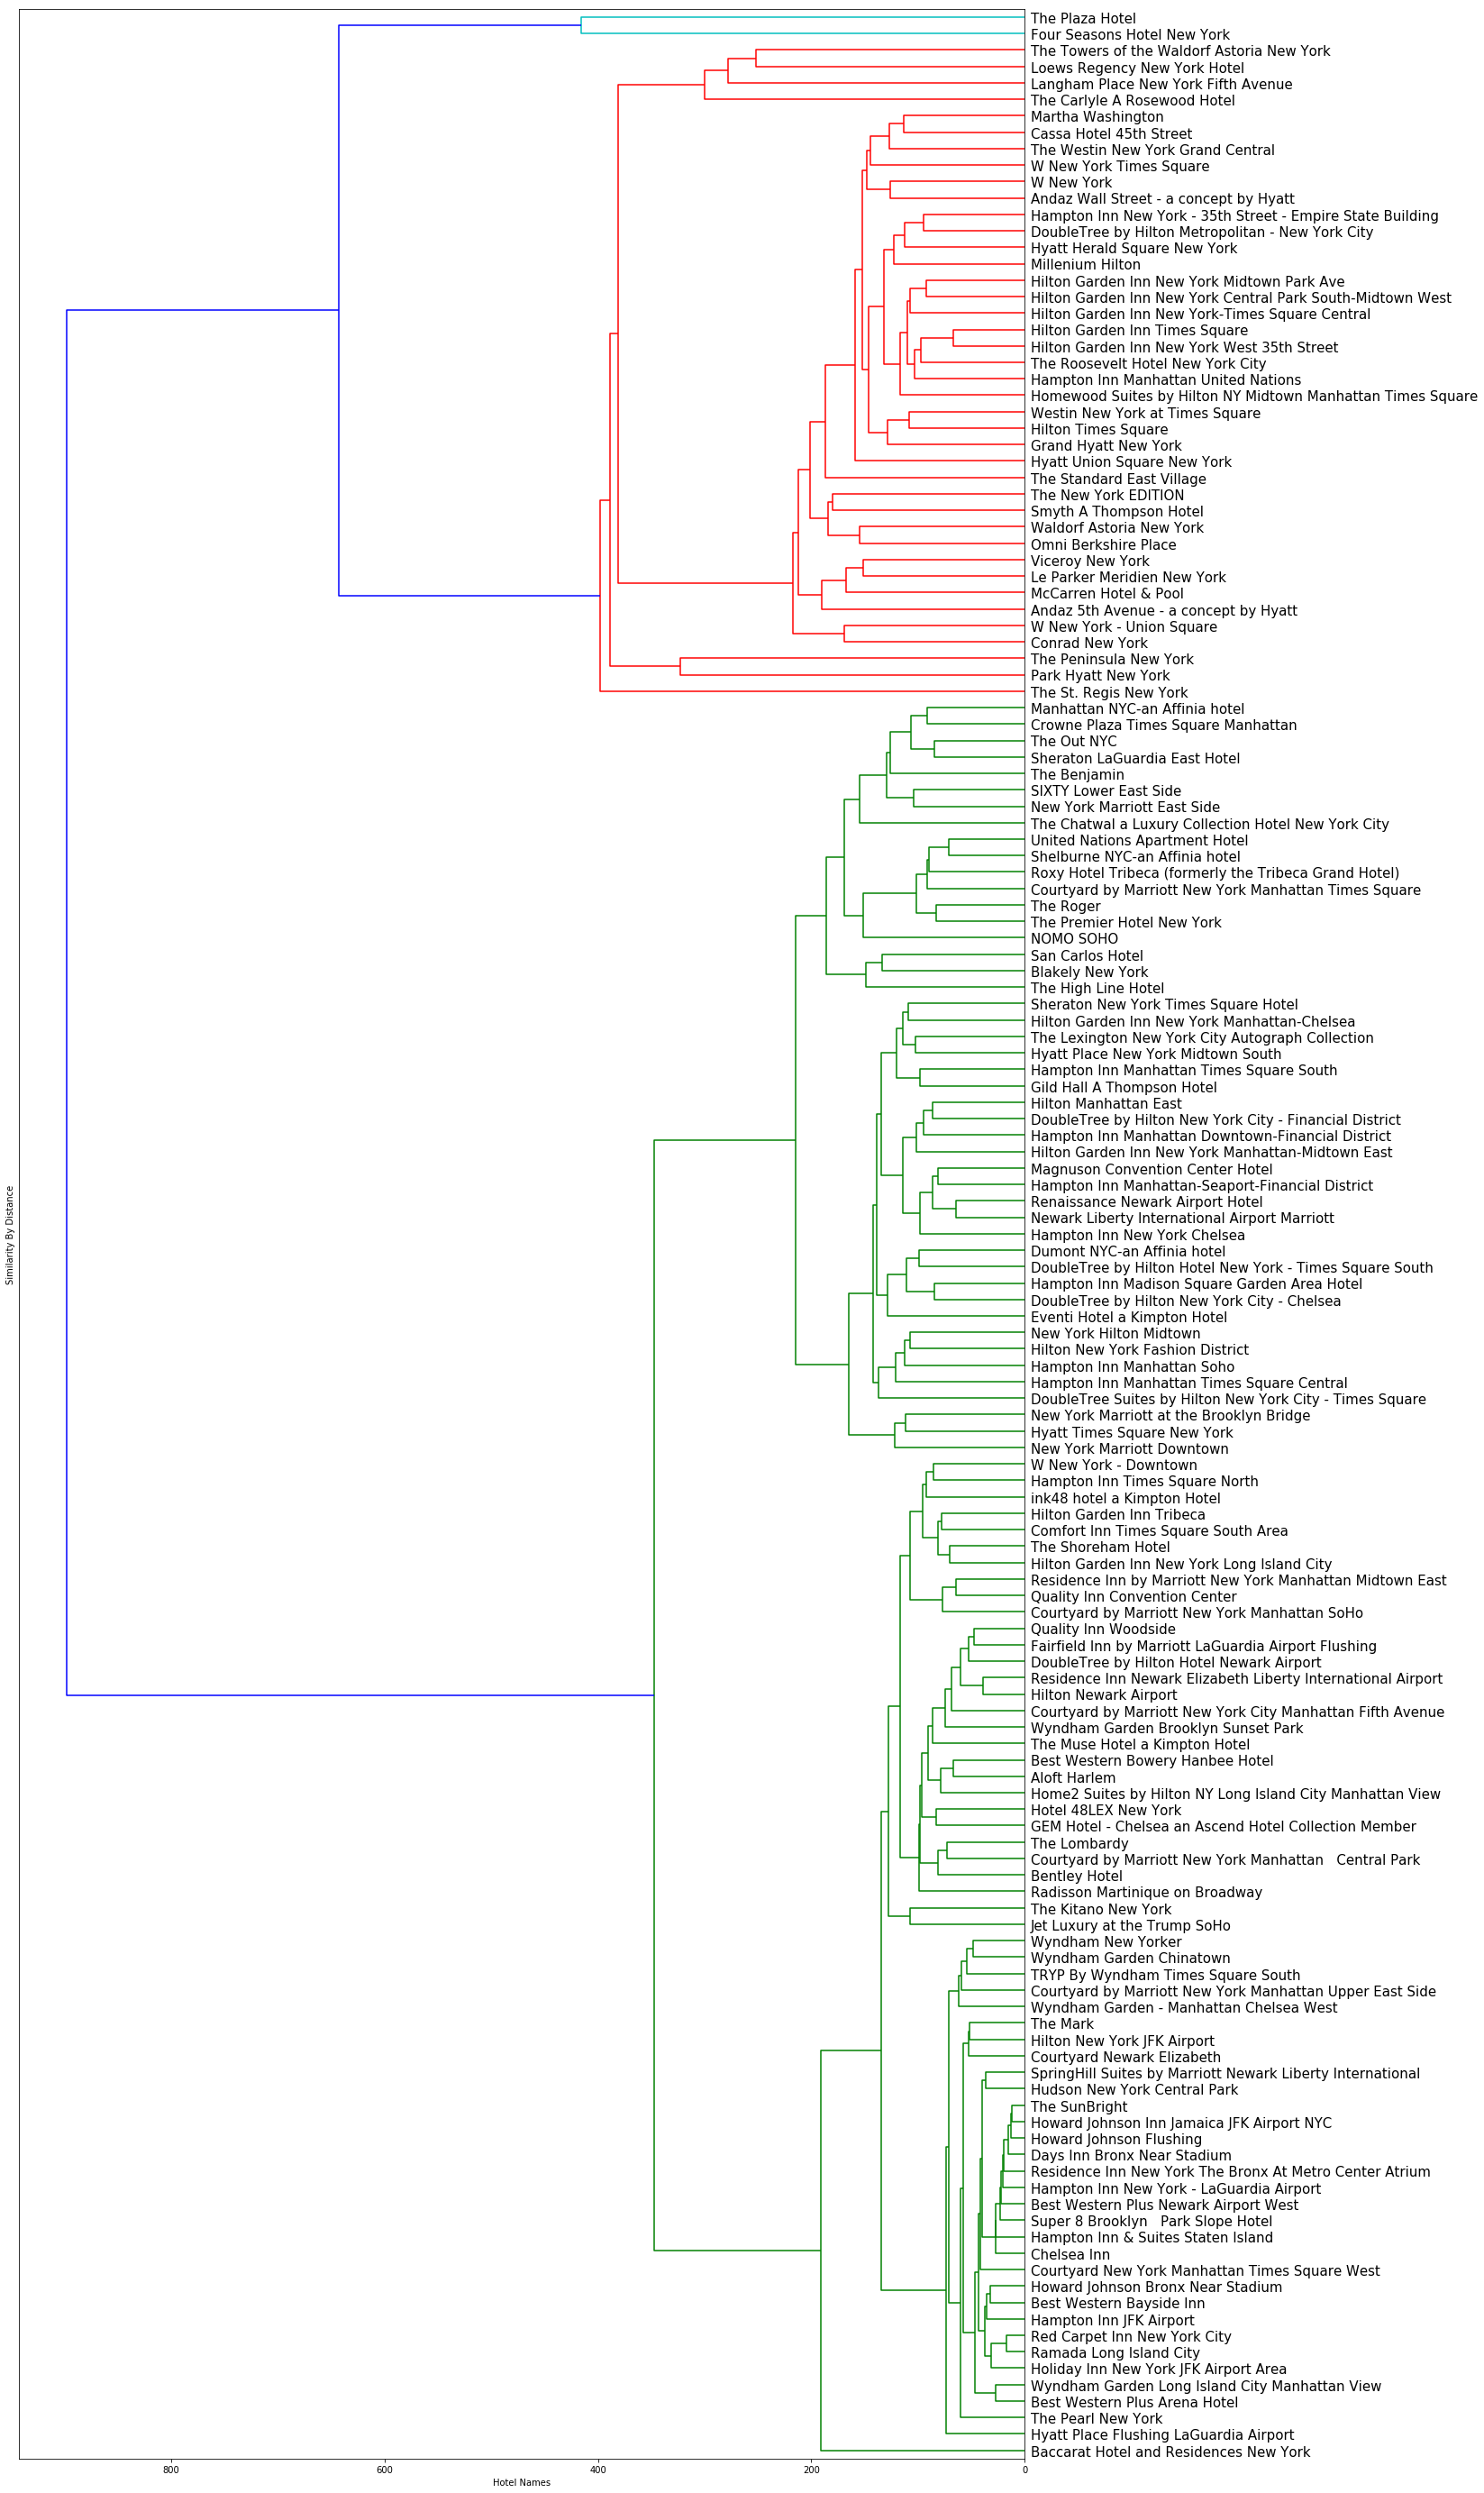

In [12]:
# Creating the Hierarchical data 
hierarchicalData = hac.linkage(NormalizedPrices, 'ward')

# Dendrogram's legend configuration.
plt.figure(figsize=(20, 50))
plt.ylabel('Similarity By Distance')
plt.xlabel('Hotel Names')

hac.dendrogram( Z=hierarchicalData, leaf_rotation=0.0, leaf_font_size=15.0, labels=NormalizedPrices.index, orientation='left')
plt.savefig(folderPath+outputFolder+'Dendrogram-ward-2.png')
plt.show()

# Bisecting K-Means

In [13]:
# In order to make predictions, we will use BisectingKMeans from the pyspark.ml.clustering library.
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [14]:
# opening the file.
NormalizedPrices = spark.read.csv(folderPath+outputFolder+'NormalizedPrices.csv', header=True, inferSchema=True)

# Creating a columns List and pop'ing the first (empty) column.
columnsList = NormalizedPrices.columns
columnsList.pop(0)

# Creating the Vector-Assembler that will handle and create the 'features' column.
vecAssembler = VectorAssembler(inputCols = columnsList, outputCol='features')

# Converting data from each row into the"features" vactor column.
data = vecAssembler.transform(NormalizedPrices)

# Creating the Scaler to fit the feature' vectors into a scaleable comparison between each other.
# withStd = with unit standard deviation (S^2, S = Variance)
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True)

# According to the Standard Deviation, we fit the vectors of each Hotel into a scaler for future visual representation.
scalerModel = scaler.fit(data)

# Transformin the scaled data into a Table.
clusterData = scalerModel.transform(data)

# Creating a 'Bisecting K Means' instance, setting the 'scaledFeatures' (Standard Deviations) as the current features to check.
bkmeans = BisectingKMeans(featuresCol='scaledFeatures')
bkmeans.setK(4)

# Creating a model for the 'Bisecting K Means' for future comput-cost.
model = bkmeans.fit(clusterData)

# Saving the sum-total of distances between the cluster' centers and their relevant cluster points.
cost = model.computeCost(clusterData)
print('The Cost (Sum total of the points distances from their centers): {0} '''.format(cost))

# Saving the predictions.
predictions = model.transform(clusterData)

# Savin the predictions into a file.
predictions.toPandas().to_csv(folderPath+outputFolder+'Predictions.csv',encoding='ISO-8859-1',index=False, header=True)

The Cost (Sum total of the points distances from their centers): 16383.364340934773 


In [15]:
# Summerizing the Predictions for each hotel.
# For example; for the hotel "Andaz 5th Avenue" (Second Hotel in the list), the best copoun would be Copoun #2.
predictions = predictions.select('Hotel Name', 'prediction')

predictions.distinct().show()

+--------------------+----------+
|          Hotel Name|prediction|
+--------------------+----------+
|Howard Johnson Br...|         0|
|DoubleTree by Hil...|         1|
| Hilton Times Square|         2|
|Courtyard by Marr...|         0|
|Best Western Plus...|         0|
|Best Western Plus...|         0|
|Residence Inn New...|         0|
|The Peninsula New...|         2|
|Wyndham Garden - ...|         0|
|Best Western Bays...|         0|
|Residence Inn by ...|         0|
|Hampton Inn New Y...|         1|
|GEM Hotel - Chels...|         0|
|          W New York|         2|
|Sheraton New York...|         1|
|Cassa Hotel 45th ...|         2|
|Hudson New York C...|         0|
|Courtyard by Marr...|         0|
|Le Parker Meridie...|         2|
|TRYP By Wyndham T...|         0|
+--------------------+----------+
only showing top 20 rows



In [16]:
# From the sum-total of recommendations, it seems that copoun number 1, 2 and 3 are vastly more represented than 
# copoun number 4, at least when it comes to recommendations.
predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   41|
|         3|    7|
|         2|   39|
|         0|   62|
+----------+-----+

